In [1]:
import os
import shutil
import flopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ! Custom modules
from utils import pht3d_fsp
from utils.tools import calculate_MAS_sums, clear_directory
from utils.pht3d_utils import copy_pht3d_datab, run_pht3d_program

clear_directory()

In [2]:
data_folder = 'case1'
model_name = 'case1_modflow'
model_ws = './models_folder/' + data_folder

Lx = 150.0
Ly = 1.0
Lz = 1.0

nlay = 1
nrow = 1
ncol = 150

delr = [1.0] * ncol 
delc = [1.0]
top = 1.0
botm = 0.0

hk = 1.0

nper = 1
perlen = [1826,]
nstp = [200,]
steady = [True,]

model = flopy.modflow.Modflow(modelname=model_name, model_ws=model_ws, exe_name='./bin/mf2005')
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=delr, delc=delc, top=top, botm=botm,
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[0, 0, -1] = -1
ibound[0, 0, 0] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[0, 0, 0] = 4.725
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=strt)

lpf = flopy.modflow.ModflowLpf(model, hk=hk, laytyp=1, ipakcb=53)

chd_data = {0: [[0, 0, 0, 4.725, 4.725],]}
chd = flopy.modflow.ModflowChd(model, stress_period_data=chd_data)

lmt = flopy.modflow.ModflowLmt(model, output_file_name='mt3d_link.ftl')

stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(model, stress_period_data=stress_period_data, compact=True)
pcg = flopy.modflow.ModflowPcg(model=model)

model.write_input()
success, mfoutput = model.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

R2 score:  1.0


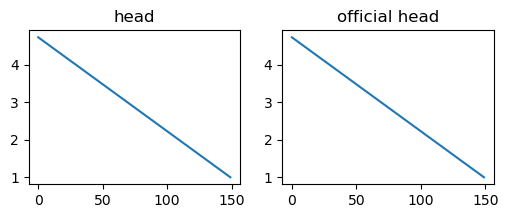

In [3]:
head = flopy.utils.binaryfile.HeadFile(model_ws+'/'+model_name+".hds").get_alldata()
head_official = flopy.utils.binaryfile.HeadFile("./official_examples/ex01_pht3d/mf2k/heads.dat").get_alldata()

plt.figure(figsize=(6,2))
plt.subplot(121)
plt.plot(head[-1, 0, 0])
plt.title("head")
plt.subplot(122)
plt.plot(head_official[-1, 0, 0])
plt.title("official head")

print("R2 score: ", r2_score(np.ravel(head_official), np.ravel(head)))

In [4]:
## Create PHT3D Reactive Transport Model, supported by PHT3D-FSP
## Define "spec", calling PHT3D-FSP (adopt function variables as needed)
spec = pht3d_fsp.create(
    xlsx_path="./", 
    xlsx_name=f"./data/{data_folder}/pht3d_species.xlsx",
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    ph_os=2,
    ph_temp=25,
    ph_asbin=1,
    ph_eps_aqu=1e-10,
    ph_ph=1e-3,
    # ph_print=0,
    ph_cb_offset=0,
    # ph_surf_calc_type="-diffuse_layer",
    write_ph="yes"
)
# Move the pht3d_ph.dat file into the models_folder
source = 'pht3d_ph.dat'
destination = os.path.join(model_ws, 'pht3d_ph.dat')
shutil.move(source, destination)

'./models_folder/case1\\pht3d_ph.dat'

In [5]:
# Define SSM and RCH data (for the SSM package) for each stress period
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict() # ... to check the key words
# print(itype)
# {'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}

chd_spec={}

for i in range(1):
    for key in spec.keys():
        chd_spec[key]=spec[key][0,0,0]

    chd_spec['Species'] = 1.0
    chd_spec['ph'] = 7.3
    chd_spec['pe'] = 4.2
    
    ssm_per=[0,0,0,0.0,itype['CHD']]
    for key in spec.keys():
        ssm_per.append(chd_spec[key])
    
    ssm_data[i] = ssm_per

ssm_data

{0: [0, 0, 0, 0.0, 1, 1.0, 7.3, 4.2]}

In [6]:
model_name = 'case1_mt3dms'
icbund = np.abs(ibound)

mt = flopy.mt3d.Mt3dms(modelname=model_name, model_ws=model_ws, exe_name='./bin/mt3dms',
                      ftlfilename='mt3d_link.ftl',modflowmodel=model, namefile_ext='nam_pht3d')

prsity = 0.25

## Define FloPy packages
exec(f'btn = flopy.mt3d.Mt3dBtn(mt, \
                                nper=nper, perlen=perlen, nstp=nstp,\
                                nlay=nlay, ncol=ncol, nrow=nrow, \
                                laycon=[1], prsity=prsity, icbund=icbund, nprs=0, mxstrn=100000, tsmult=1, timprs=[0, 50000], \
    ncomp={pht3d_fsp.create.ncomp}, mcomp={pht3d_fsp.create.mcomp}, {pht3d_fsp.create.sconc_btn})') # call BTN package in this way to invoke PHT3D-FSP variables

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.75)
dsp = flopy.mt3d.Mt3dDsp(mt, al=0.0, trpt=0.1, trpv=0.1, multiDiff=True,dmcoef=0.0,)
gcg = flopy.mt3d.Mt3dGcg(mt, isolve=2, cclose=1.e-10)
exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data, mxss=1000)')
mt.write_input()

In [7]:
# Manually add the PHC reaction package to the nam file and push out as pht3d.nam
s='PHC               39  pht3d_ph.dat\n'
namfiletxt=open(model_ws + '/'+ mt.namefile, 'r').read()
pht3d_nam = namfiletxt+s
file = open(model_ws + '/pht3d.nam','w')
file.write(pht3d_nam)
file.close()

In [8]:
copy_pht3d_datab(source_folder=data_folder)

run_pht3d_program(work_dir=data_folder)

The file pht3d_datab.dat has been copied to the model folder.
 PHT3D - [Version 2.10]
 Reactive Multicomponent Transport based on MT3DMS and PHREEQC-2.
 Developed by Henning Prommer / Vincent Post

 Using NAME File: pht3d.nam                                         

 STRESS PERIOD NO.    1
 Calling PHREEQC to equilibrate SSM solutions

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    9.1300    

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:   7.500     Total Elapsed Time:   7.5000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4286      [K,I,J]    1    1  150
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4286      [K,I,J]    1    1  150
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  1:  Max

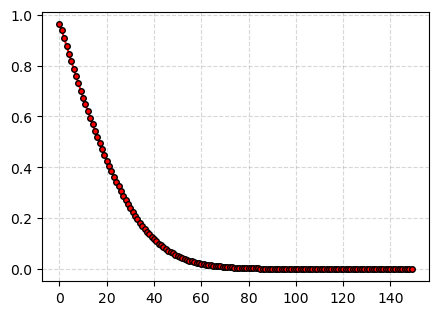

In [9]:
Species = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D001.UCN').get_alldata()

fig = plt.figure(figsize=(5, 3.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(Species[1,0,0], marker='o', color='red', markersize=4, markeredgecolor='black')
ax.grid(visible=True, which='major', axis='both', alpha=0.5, linestyle='--')

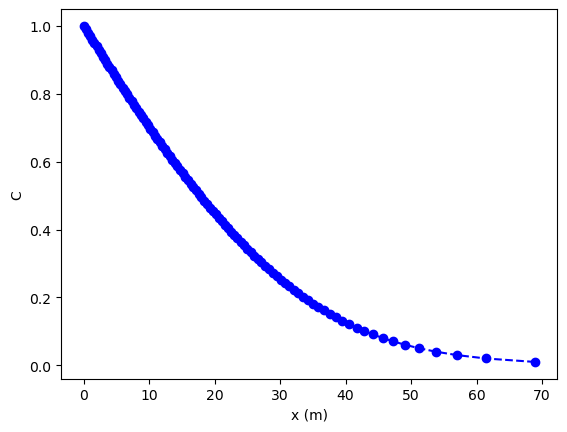

In [10]:
vp = 0.1
vmax = 4.77e-3
K = 0.5
C0 = 1.0

C_values = np.linspace(0, 1, 100)

x_values = (vp / vmax) * (K * np.log(C0/C_values) + C0 - C_values)

plt.figure()
plt.plot(x_values, C_values, marker='o', linestyle='--', color='b')
plt.xlabel('x (m)')
plt.ylabel('C')
plt.show()


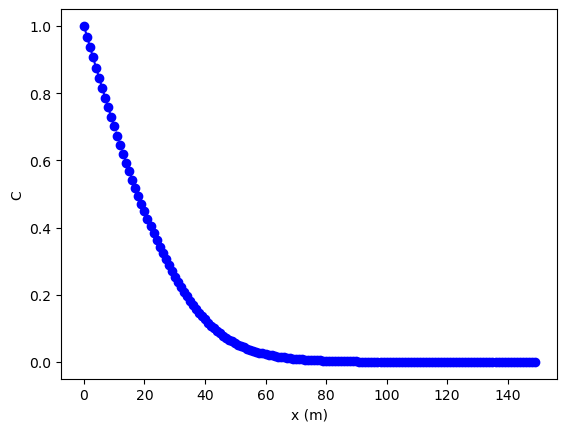

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect

# 定义寻找C的函数
def find_C(x_target, vp=0.1, vmax=4.77e-3, K=0.5, C0=1.0):
    def f(C):
        return (vp / vmax) * (K * np.log(C0/C) + C0 - C) - x_target
    C = bisect(f, 1e-6, 1)
    return C

# 创建x值的数组
x_values = np.linspace(0, 149, 150)

# 对每个x值计算对应的C值
C_values = [find_C(x) for x in x_values]

# 绘制图形
plt.figure()
plt.plot(x_values, C_values, marker='o', linestyle='--', color='b')
plt.xlabel('x (m)')
plt.ylabel('C')
plt.show()


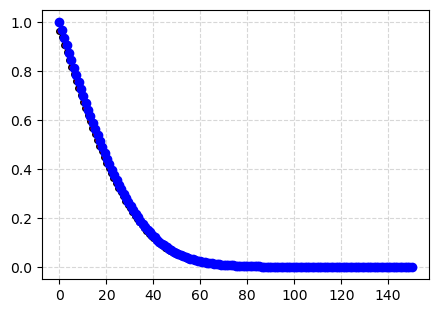

In [13]:
fig = plt.figure(figsize=(5, 3.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(Species[1,0,0], marker='o', color='red', markersize=4, markeredgecolor='black')
ax.grid(visible=True, which='major', axis='both', alpha=0.5, linestyle='--')
plt.plot(x_values, C_values, marker='o', linestyle='--', color='b')

In [16]:
r2_score(Species[1,0,0], C_values)

0.9977658987045288